In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in E.coli - BacDrop

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/ecoli_data_processed.h5ad")


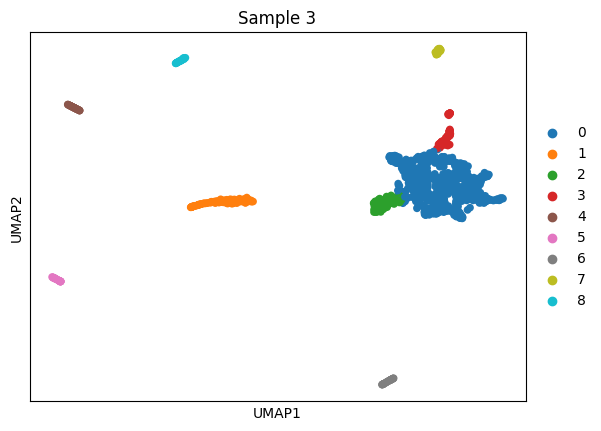

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
gene 500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 600
Both NB and ZINB not converged! Using NB without starting params
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not

In [6]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,NaN,NaN,NaN,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412985,...,NaN,NaN,NaN,0.034588,0.033392,0.001196,poi,0.034623,inf,0.001179
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,NaN,NaN,NaN,0.004069,0.006087,-0.002018,nb,0.004075,0.005521,0.000000
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238012,...,NP_313381.1,transcriptional regulator,rob,0.011190,0.013100,-0.001909,nb,0.011192,0.057329,0.000000
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,NP_313386.1,two-component regulatory system response regul...,arcA,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198068,...,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX,0.017294,0.016995,0.000299,poi,0.017314,inf,0.001407
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,YP_009502638.1,hypothetical protein,yecJ,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962


## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 13.156602771853072
Factor: 2 - Error: 12.95238375057245
Factor: 3.6180339999999998 - Error: 12.965378573141754
Factor: 2 - Error: 12.95238375057245
Factor: 2.61803399102434 - Error: 12.667321531559748
Factor: 3.000000004452737 - Error: 12.397454604301306
Factor: 3.2360679837762825 - Error: 13.217678943313965
Factor: 2.8541019703478856 - Error: 13.008200734144262
Factor: 3.090169948603714 - Error: 12.656096625992747
Factor: 2.944271914498863 - Error: 13.086838882484836
Factor: 3.0344418582420083 - Error: 12.487976417536066
Factor: 2.9787137682881344 - Error: 12.927326073009453
Factor: 3.0131556219216282 - Error: 12.680012955346927
Factor: 2.9918693857570258 - Error: 12.723391454630745
Factor: 3.0050250031664154 - Error: 12.932266208937312
Factor: 2.9968943844707043 - Error: 12.773385699056684
Factor: 3.0019193831616557 - Error: 12.454905585900812
Factor: 2.9988137631796237 - Error: 12.681509149953538
Factor: 3.0007331418798615 - Error: 12.177635026586433
Factor: 3.001

In [8]:
importlib.reload(cd)
xmin=1

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

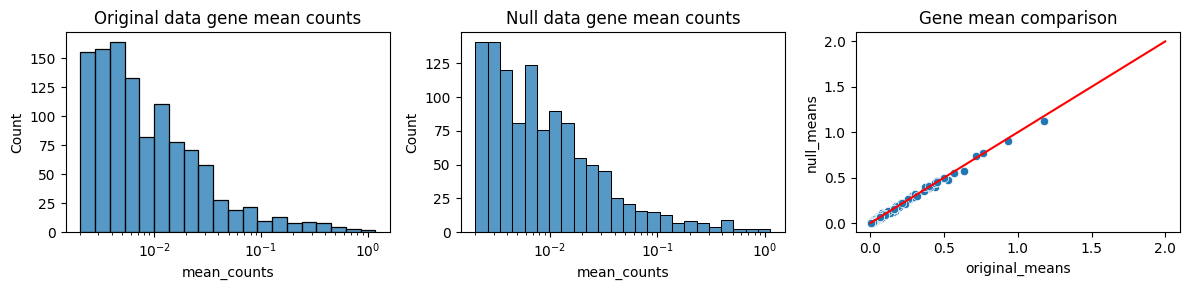

SignificanceResult(statistic=0.9124185531907208, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

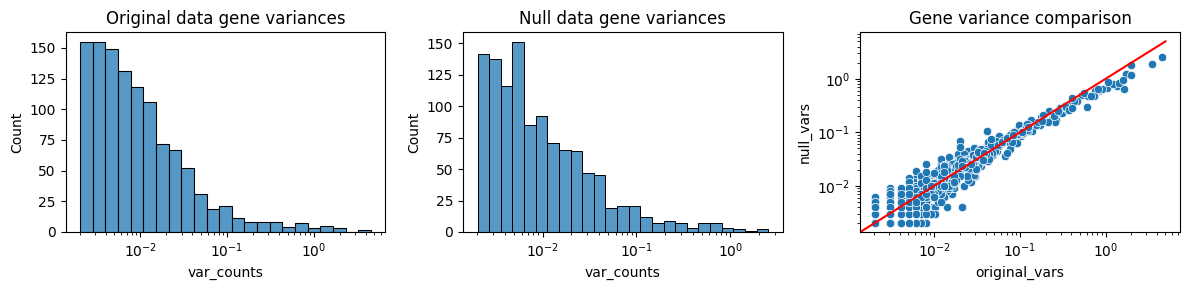

SignificanceResult(statistic=0.9049673396611749, pvalue=0.0)
[[1.         0.97813804]
 [0.97813804 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

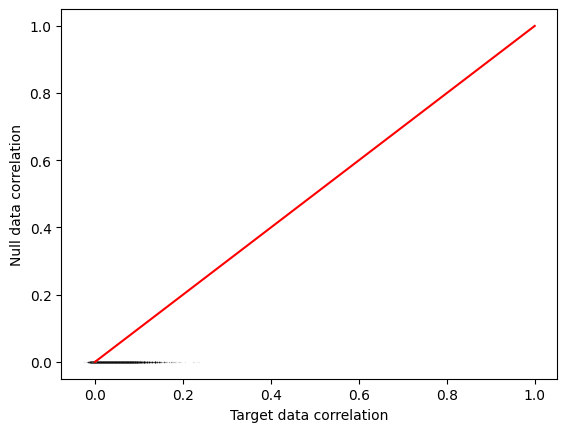

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


30


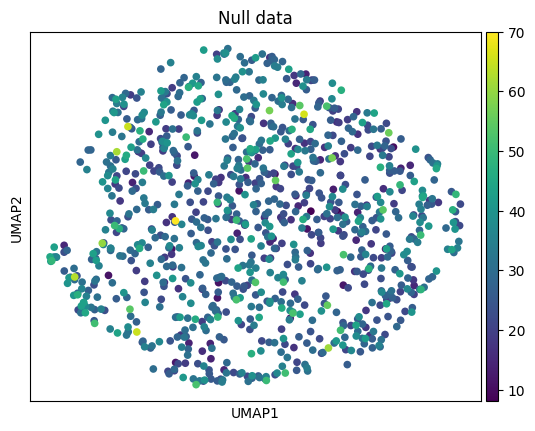

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_ecoli.h5ad")

In [53]:
n_splits = 20
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    
    while twoclust is False:
        if nclust < 2:
            if was_greater:
                res2 += 0.01
            else:
                res2 += 0.05
        else:
            res2 -= 0.01
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

resolution: 0.06, clusters: 1
resolution: 0.11, clusters: 1
resolution: 0.16, clusters: 1
resolution: 0.21, clusters: 1
resolution: 0.26, clusters: 1
resolution: 0.31, clusters: 1
resolution: 0.36, clusters: 2
split 1/20 - Resolution 0.36
resolution: 0.36, clusters: 2
split 2/20 - Resolution 0.36
resolution: 0.36, clusters: 1
resolution: 0.41, clusters: 2
split 3/20 - Resolution 0.41
resolution: 0.41, clusters: 3
resolution: 0.4, clusters: 3
resolution: 0.39, clusters: 3
resolution: 0.38, clusters: 3
resolution: 0.37, clusters: 2
split 4/20 - Resolution 0.37
resolution: 0.37, clusters: 2
split 5/20 - Resolution 0.37
resolution: 0.37, clusters: 2
split 6/20 - Resolution 0.37
resolution: 0.37, clusters: 3
resolution: 0.36, clusters: 2
split 7/20 - Resolution 0.36
resolution: 0.36, clusters: 1
resolution: 0.41, clusters: 4
resolution: 0.4, clusters: 3
resolution: 0.39, clusters: 2
split 8/20 - Resolution 0.39
resolution: 0.39, clusters: 2
split 9/20 - Resolution 0.39
resolution: 0.39, clu

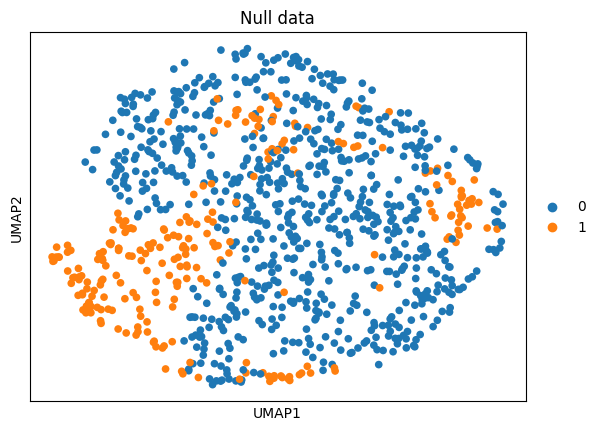

In [40]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [41]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals_dict[best_split]}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.0625
Cluster 7 - DE genes: 29; Minimum q value: 0.034482758620689655
Cluster 3 - DE genes: 23; Minimum q value: 0.043478260869565216
Cluster 2 - DE genes: 26; Minimum q value: 0.038461538461538464
Cluster 6 - DE genes: 44; Minimum q value: 0.02857142857142857
Cluster 8 - DE genes: 22; Minimum q value: 0.045454545454545456
Cluster 5 - DE genes: 32; Minimum q value: 0.03125
Cluster 4 - DE genes: 27; Minimum q value: 0.037037037037037035
Cluster 1 - DE genes: 42; Minimum q value: 0.034482758620689655


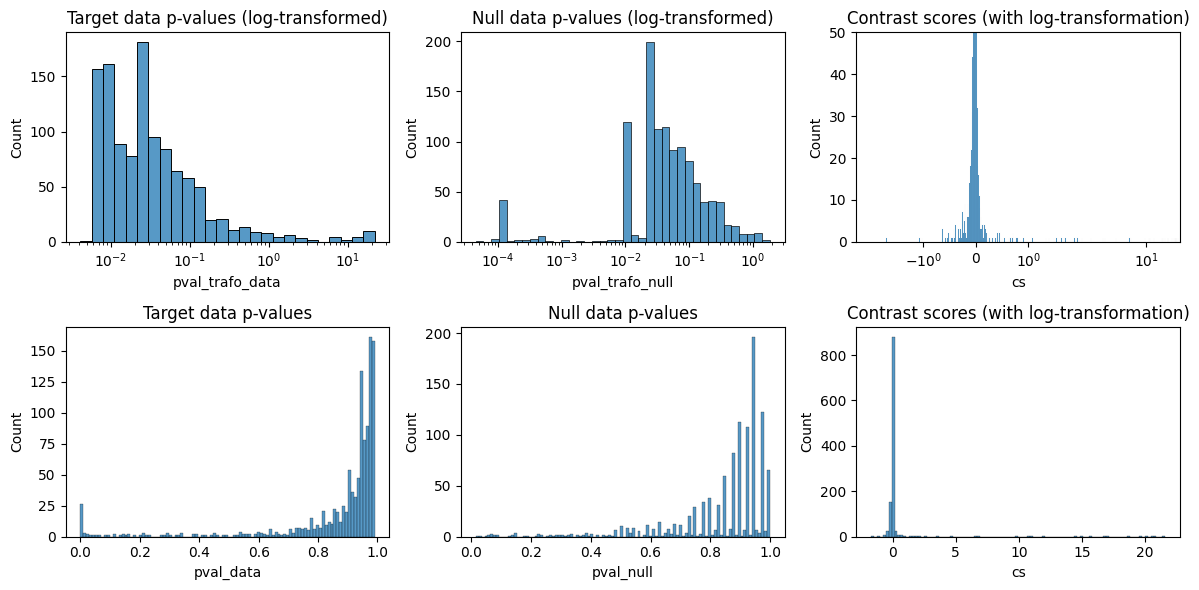

In [42]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [43]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.062500     16
0.071429     12
0.090909     16
0.111111      1
0.134615      7
           ... 
0.441953      1
0.444005      1
0.448900     14
0.450830     10
1.000000    352
Name: q, Length: 94, dtype: int64

cluster 7
0.034483      29
0.064516       2
0.090909       2
0.114286       2
0.138889       1
0.263158       2
0.358974       1
0.390244       2
0.441860       2
0.568182       1
0.608696       2
0.638298       1
0.687500       1
0.693878       1
0.700000       1
0.705882       1
0.807692       1
1.000000    1083
Name: q, dtype: int64

cluster 3
0.043478     23
0.080000      2
0.113636     19
0.177778      1
0.191489      2
0.211538      5
0.226415      1
0.229508      8
0.269841      2
0.323077      2
0.328358      2
0.362319      2
0.380282      2
0.394737      5
0.397436      2
0.400000      2
0.407407      1
0.426829      1
0.440476      2
0.447059      1
0.517241      2
0.528090      2
0.560000     11
0.594059      1
0.649123     13
0.669565      1
0.706349     1

In [44]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
cds-NP_312199.1,6.686998e-12,0.501839,11.174769,0.299436,10.875333,0.0625
cds-NP_312936.1,6.989417e-08,0.928090,7.155559,0.032410,7.123149,0.0625
cds-NP_309021.1,9.772379e-06,0.904701,5.010000,0.043495,4.966505,0.0625
cds-NP_312211.1,2.767991e-05,0.531131,4.557835,0.274799,4.283037,0.0625
cds-NP_311189.1,1.724542e-04,0.896169,3.763326,0.047610,3.715716,0.0625
...,...,...,...,...,...,...
cds-NP_311315.1,8.556099e-01,0.148056,0.067724,0.829574,-0.761850,1.0000
cds-NP_312187.1,8.133233e-01,0.136892,0.089737,0.863622,-0.773886,1.0000
cds-NP_309768.1,5.139163e-01,0.044597,0.289108,1.350694,-1.061587,1.0000
cds-NP_308124.1,9.595448e-01,0.079177,0.017935,1.101402,-1.083467,1.0000


In [45]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [46]:
data_gene_nonzero.write(data_path + "/ecoli_data_processed_cluster.h5ad")

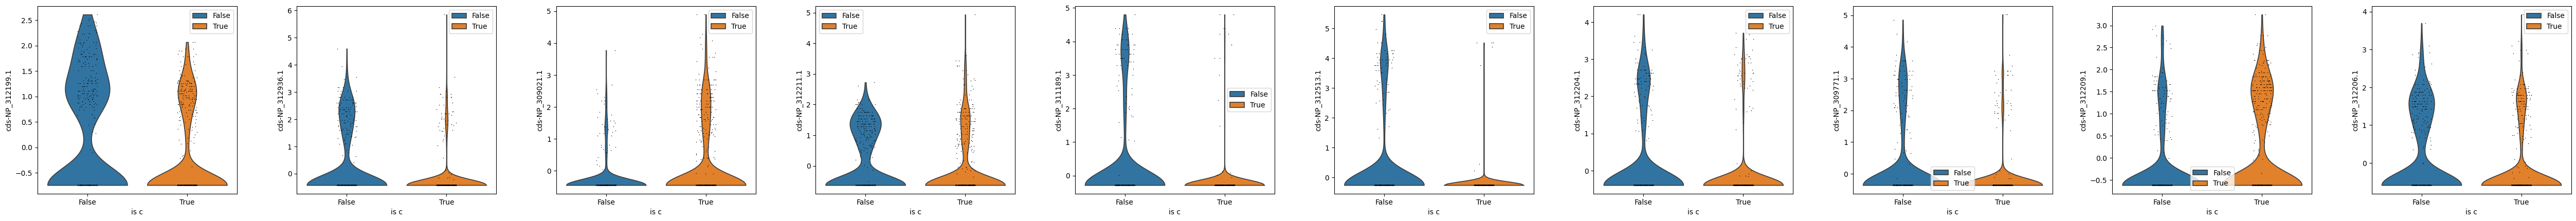

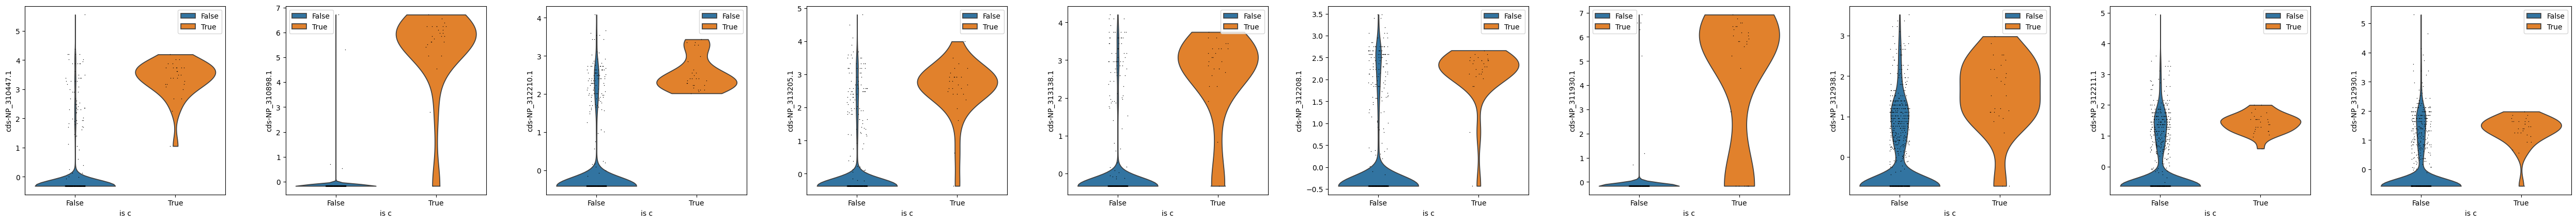

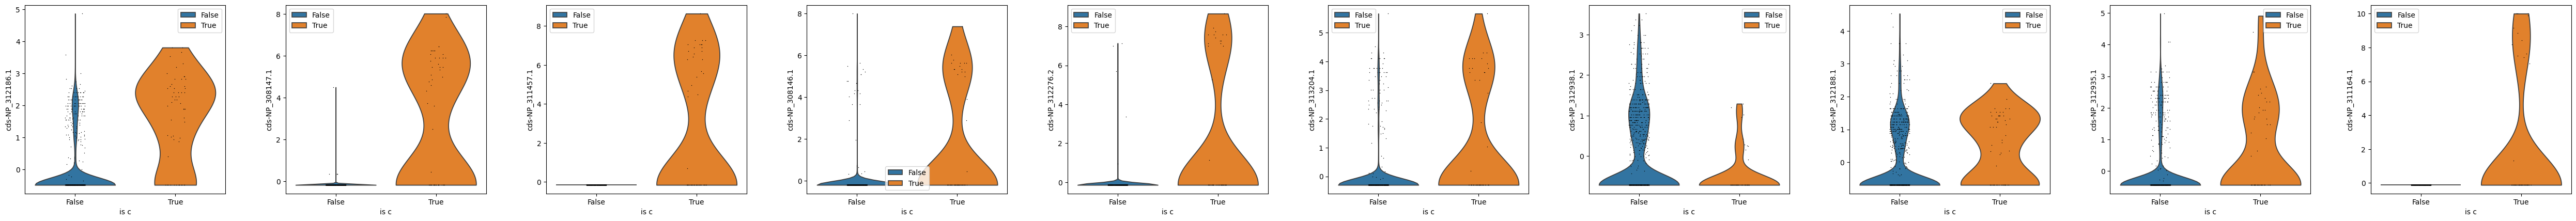

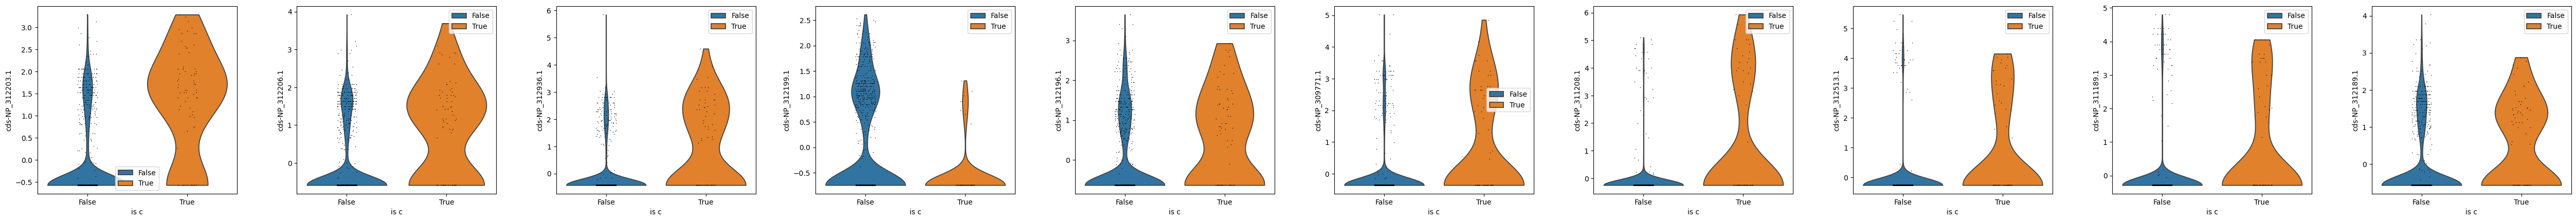

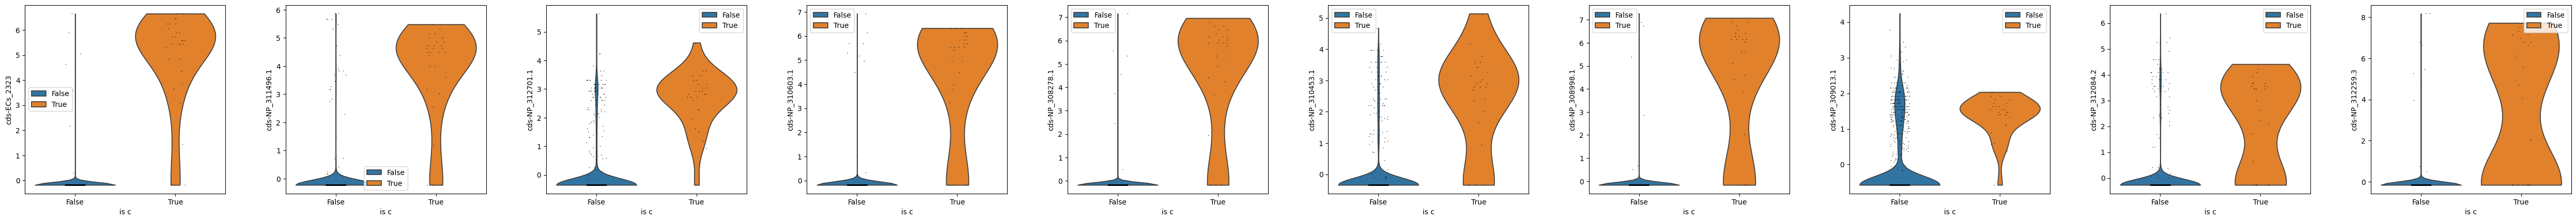

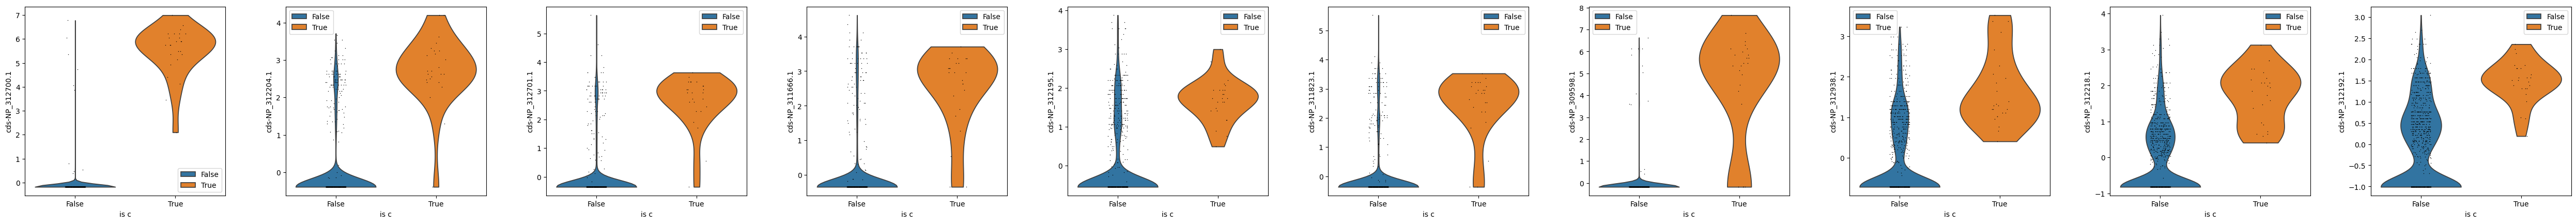

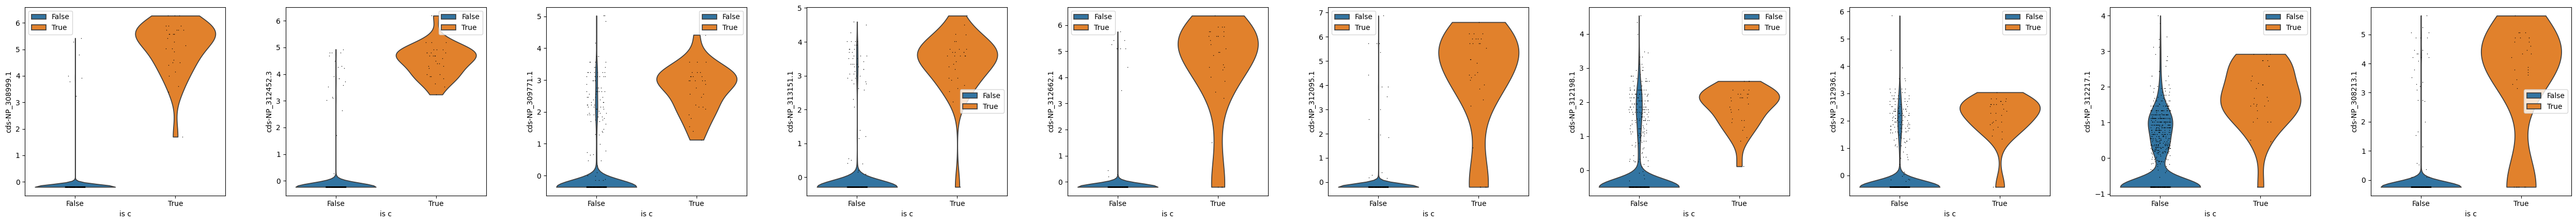

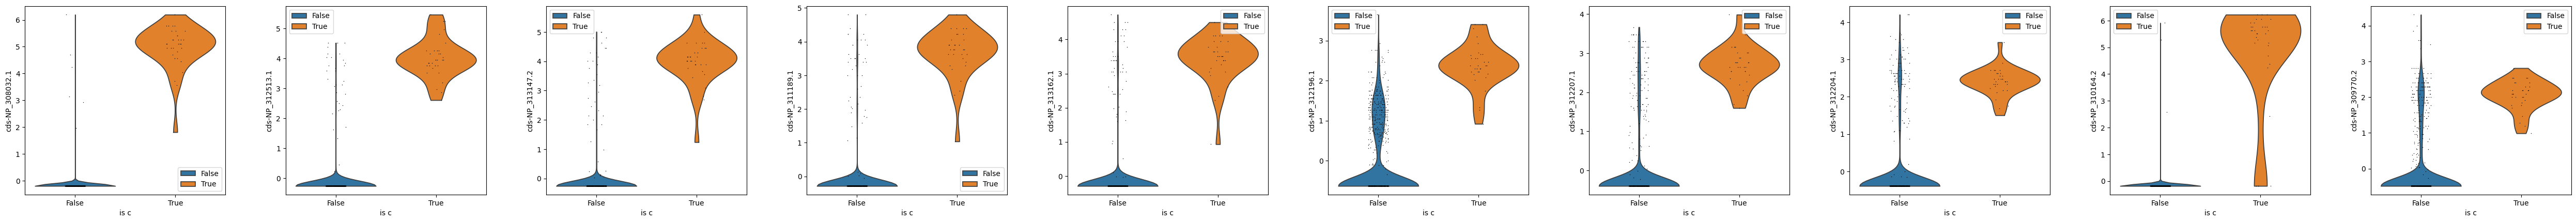

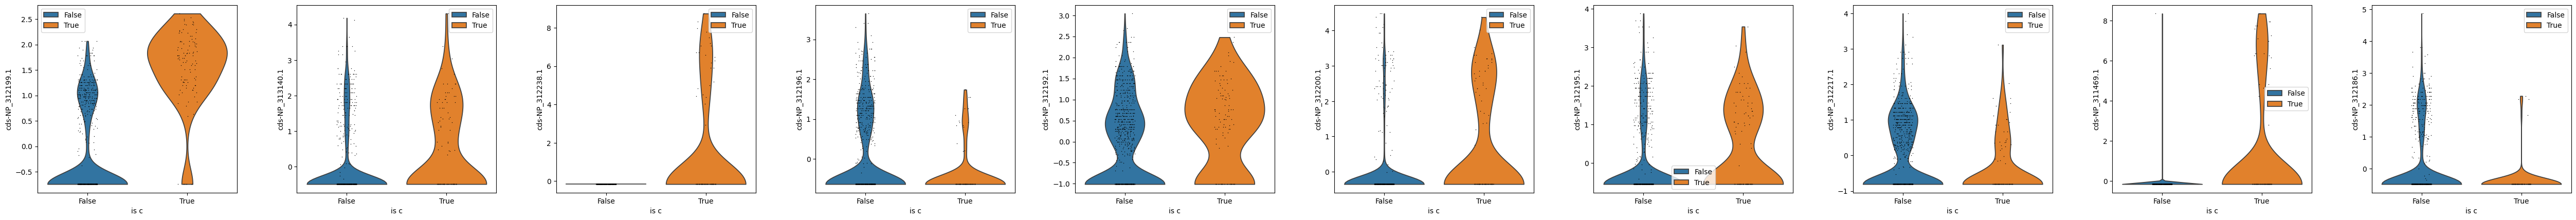

In [47]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [48]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-ECs_1431,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
cds-ECs_2321,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,NaN,NaN,NaN,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-ECs_2323,34,0.034588,0.034003,96.541200,34.0,3.555348,34,0.033393,False,1.412985,...,NaN,NaN,NaN,0.034588,0.033392,0.001196,poi,0.034623,inf,0.001179
cds-ECs_2640,3,0.004069,0.004061,99.694812,4.0,1.609438,3,0.006087,False,0.012463,...,NaN,NaN,NaN,0.004069,0.006087,-0.002018,nb,0.004075,0.005521,0.000000
cds-ECs_2775,3,0.003052,0.003047,99.694812,3.0,1.386294,3,0.003043,False,0.178894,...,NaN,NaN,NaN,0.003052,0.003043,0.000009,poi,0.011504,inf,0.734309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_313381.1,10,0.011190,0.011128,98.982706,11.0,2.484907,10,0.013099,False,0.238012,...,NP_313381.1,transcriptional regulator,rob,0.011190,0.013100,-0.001909,nb,0.011192,0.057329,0.000000
cds-NP_313386.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,NP_313386.1,two-component regulatory system response regul...,arcA,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962
cds-YP_009502594.1,17,0.017294,0.017146,98.270600,17.0,2.890372,17,0.016995,False,0.198068,...,YP_009502594.1,cytochrome d (bd-I) ubiquinol oxidase subunit X,cydX,0.017294,0.016995,0.000299,poi,0.017314,inf,0.001407
cds-YP_009502638.1,2,0.002035,0.002033,99.796541,2.0,1.098612,2,0.002030,False,0.119318,...,YP_009502638.1,hypothetical protein,yecJ,0.002035,0.002030,0.000004,poi,0.008532,inf,0.760962


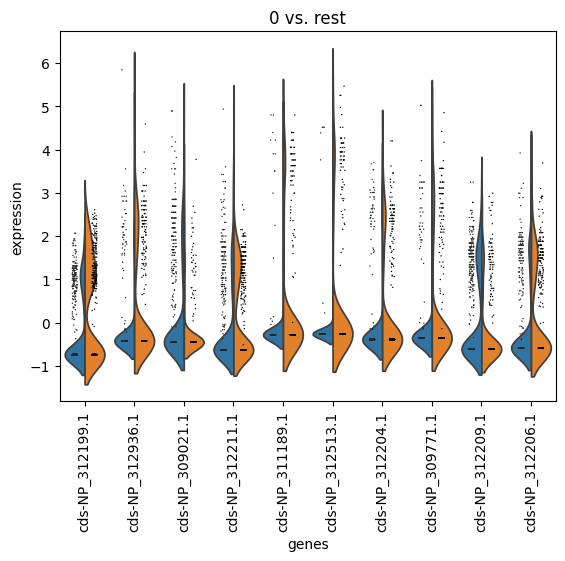

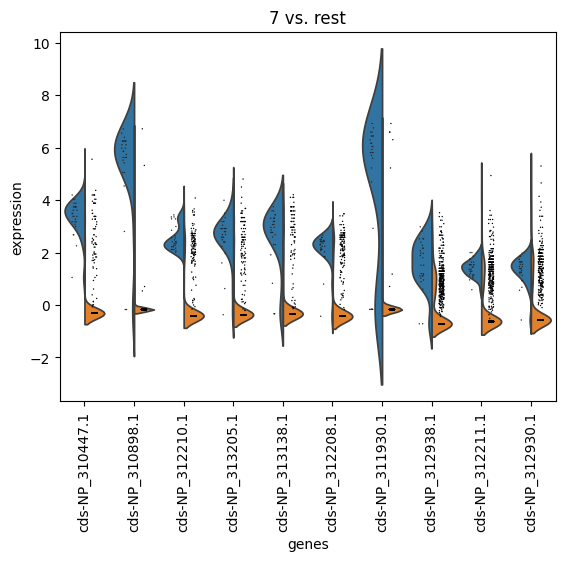

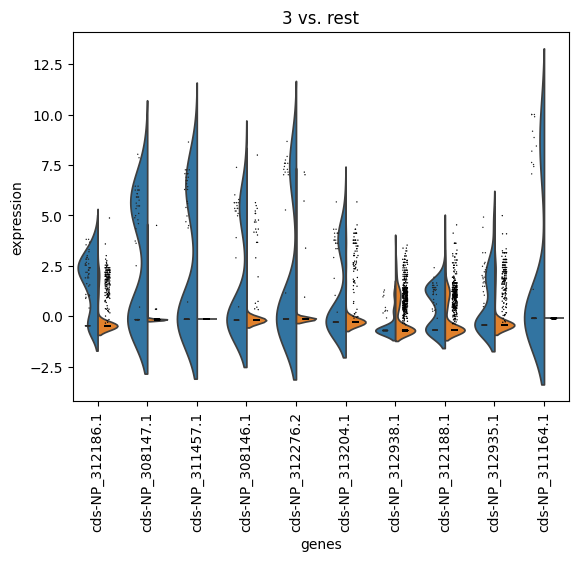

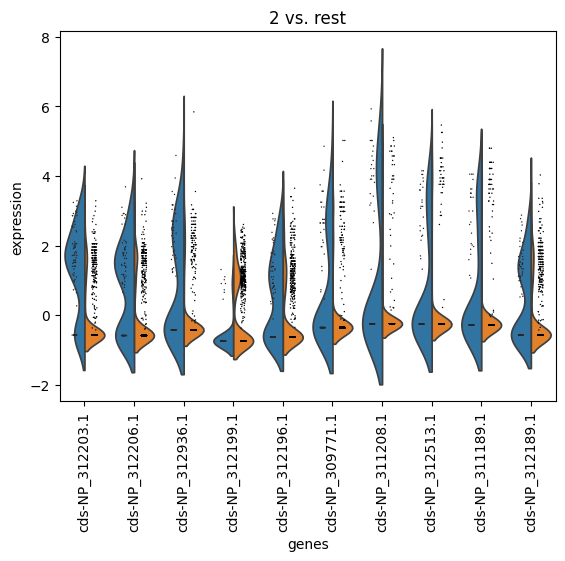

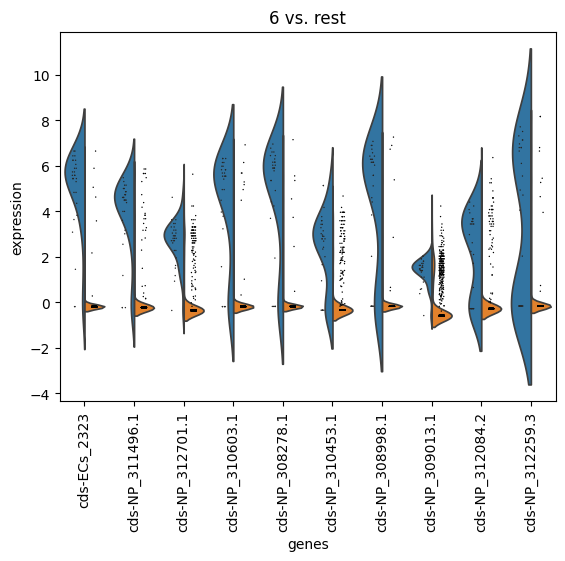

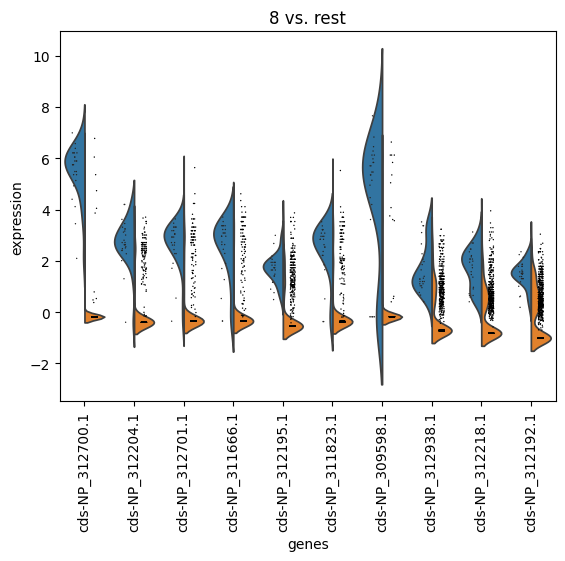

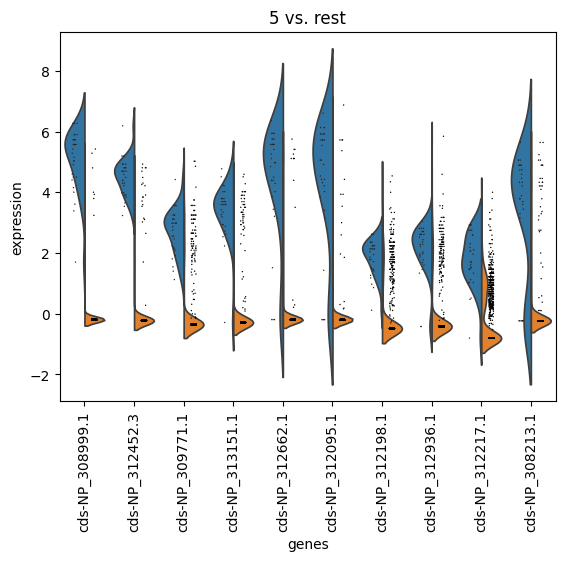

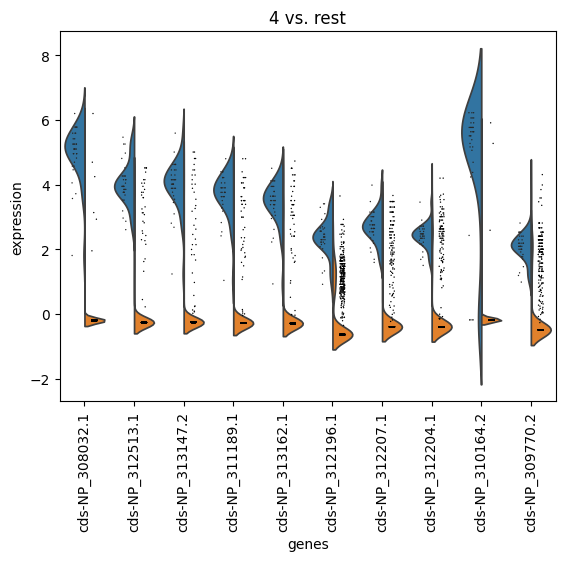

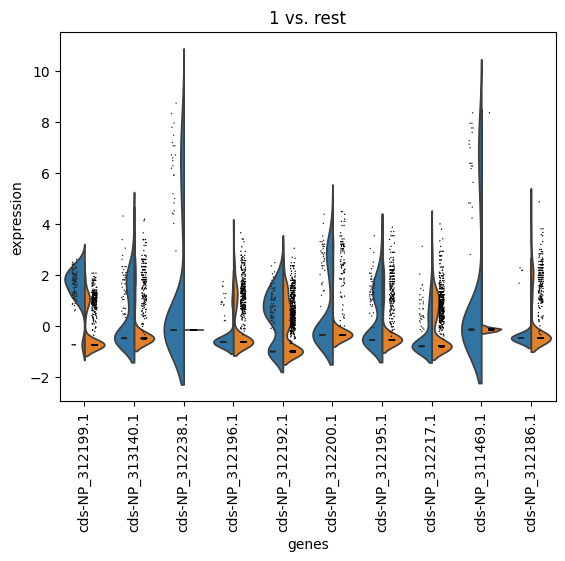

In [49]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [50]:
p_cutoff = 0.05
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].loc[data_gene_nonzero.uns["ClusterDE_results"][c]["q"] < p_cutoff,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 0
Empty DataFrame
Columns: [locus_tag, name, symbol]
Index: []
Cluster 7
                locus_tag                                          name  \
cds-NP_310447.1  ECs_2420    phenylalanine tRNA synthetase beta subunit   
cds-NP_310898.1  ECs_2871          outer membrane assembly protein AsmA   
cds-NP_312210.1  ECs_4183             50S ribosomal subunit protein L23   
cds-NP_313205.1  ECs_5178             30S ribosomal subunit protein S18   
cds-NP_313138.1  ECs_5111                        lysine tRNA synthetase   
cds-NP_312208.1  ECs_4181             30S ribosomal subunit protein S19   
cds-NP_311930.1  ECs_3903                DNA topoisomerase IV subunit A   
cds-NP_312938.1  ECs_4911             RNA polymerase beta prime subunit   
cds-NP_312211.1  ECs_4184              50S ribosomal subunit protein L4   
cds-NP_312930.1  ECs_4903         translation elongation factor EF-Tu 1   
cds-NP_309873.1  ECs_1846                           DNA topoisomerase I   
cds-NP_311684.1  EC

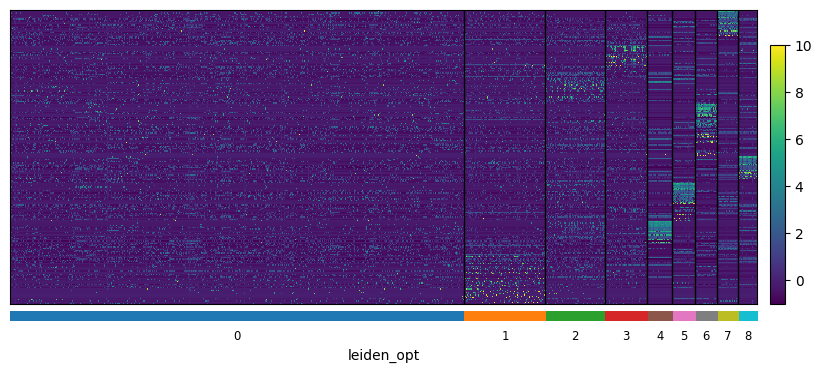

In [51]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)